----
# 第１章　はじめに
----

## 宇宙線検出器の仕組み

宇宙線検出器は下図のような構造になっています。宇宙からやってきた宇宙線がシンチレーターへと入ると、そのエネルギーからシンチレーターが蛍光を発します。その蛍光をSiPMという光検出して、その信号をArduinoでデジタル処理をします。

![alt text](https://drive.google.com/uc?id=1d88-DZJQLuaVCRAV7ZMSMOqkbjZy8qSn)


## どんな風に計測データは保存される？
宇宙線測定データは以下のような手順で保存が行われます。
1. SiPMからの出力がある一定の値（閾値）よりも大きい時にデータ保存を開始します。
2. SiPMからの出力をo～1024の整数値の値へと変換します。これは（原則として）デジタル制御は整数の値しか扱えないため必要な作業です。
3. SiPMの値、ADCの値、時間、温度の値をPCへと送り、保存されます。SiPMは直接デジタルデータとして扱えませんが、ADCの値から逆算することで間接的に得ています。



![alt text](https://drive.google.com/uc?id=1Os3awE3nXcJ6o5aYpFpn4uKhUlBnlIoD)


　

----
# 第２章　解析をはじめる準備
----
Google Colaboratoryではセッション（およそ１２時間ごと）に全てがリセットされ、それまでの計算結果もファイルも消える仕様になっています。そこで、以下の手順1～2の事前準備を毎回行うようにしましょう。

## 手順１：ライブラリのインストール、データのダウンロード
以下のコードをまずは実行してmatplotlibというグラフを描画するライブラリをインストールおよびデータのダウンロードをします。コードを実行するには、セルをクリックして選択し、コードの左側にある再生ボタンをクリックするか、キーボード ショートカット「command+return」または「Ctrl+Enter」を使用します。

###データの種類
1. **dataA**: 真上を向けて１日ぐらい測定したデータ
2. **dataB**: 76.4°傾けて数時間ぐらい測定したデータ
3. **dataC**: 59.3°傾けて半日ぐらい測定したデータ
4. **dataD**: 閾値を30→250に変更して、真上を向けて２時間ぐらい測定したデータ
5. **toshima1.dat**: 29階での測定（豊島岡）
6. **toshima2.dat**: 9回での測定（豊島岡）
7. **yamagata1.dat**: 2020.8.7測定データ（山形東）
8. **yamagata2.dat**: 2020.9.7測定データ（山形東）
9. **akita1.dat**: 湿度・気圧データ有、2020.9.4測定データ（秋田）
10. **akita2.dat**: 湿度・気圧データ有、2020.9.6測定データ（秋田）




In [ ]:
!pip install matplotlib
!wget https://kaduo.jp/storage/dataA https://kaduo.jp/storage/dataB https://kaduo.jp/storage/dataC https://kaduo.jp/storage/dataD
!wget https://kaduo.jp/storage/toshima1.dat https://kaduo.jp/storage/toshima2.dat https://kaduo.jp/storage/yamagata1.dat https://kaduo.jp/storage/yamagata2.dat https://kaduo.jp/storage/akita1.dat https://kaduo.jp/storage/akita2.dat
print('ライブラリの読み込み、データのダウンロード完了')

--2020-11-19 13:45:10--  https://kaduo.jp/storage/dataA
Resolving kaduo.jp (kaduo.jp)... 153.120.37.48
Connecting to kaduo.jp (kaduo.jp)|153.120.37.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8558943 (8.2M)
Saving to: ‘dataA.1’

dataA.1             100%[===================>]   8.16M  3.39MB/s    in 2.4s    

2020-11-19 13:45:14 (3.39 MB/s) - ‘dataA.1’ saved [8558943/8558943]

--2020-11-19 13:45:14--  https://kaduo.jp/storage/dataB
Reusing existing connection to kaduo.jp:443.
HTTP request sent, awaiting response... 200 OK
Length: 925272 (904K)
Saving to: ‘dataB.1’

dataB.1             100%[===================>] 903.59K  --.-KB/s    in 0.003s  

2020-11-19 13:45:14 (285 MB/s) - ‘dataB.1’ saved [925272/925272]

--2020-11-19 13:45:14--  https://kaduo.jp/storage/dataC
Reusing existing connection to kaduo.jp:443.
HTTP request sent, awaiting response... 200 OK
Length: 3120564 (3.0M)
Saving to: ‘dataC.1’

dataC.1             100%[===================>]   2.98M  

## 手順２：解析用クラスのインストール
解析に必要なクラスを読み込みます。CosmicWatch及びQuarknetのいずれか測定に用いた検出器に合わせて読み込むクラスを選択してください。

### CosmicWatch用解析クラス

In [ ]:
#
# ライブラリの読み込み
#
import matplotlib.pyplot as plt
import csv
import datetime
import statistics
import math

#
# Cosmic Watch解析ライブラリ（CosmicRayAnalysis）
#
class CosmicRayAnalysis ():
  # インスタンス生成時
  def __init__(self):
    None
  # データの読み込み
  def loadData(self,filename,data = []): 
    if data == []:
            data = self.initializeData()    
    pre_time = 0
    pre_deadtime = 0
    with open(filename,encoding="utf-8-sig") as f:
        reader = csv.reader(f,delimiter='\t')
        try:
            for row in reader:
                time =  int(row[2]) - pre_time
                deadtime =  int(row[5]) - pre_deadtime
                data['event'].append(int(row[0]))
                data['date'].append(datetime.datetime.strptime(row[1], '%Y-%m-%d-%H-%M-%S.%f'))
                data['time'].append(time)
                data['adc'].append(float(row[3]))
                data['sipm'].append(float(row[4]))
                data['deadtime'].append(deadtime)
                data['temp'].append(float(row[6]))
                pre_time =  int(row[2])
                pre_deadtime =  int(row[5])

                if len(row)==9:   #湿度・気圧データがあるとき
                  data['hum'].append(float(row[7]))   #湿度データ
                  data['pres'].append(float(row[8]))  #気圧データ
                else:
                  data['hum'].append(0)
                  data['pres'].append(0)

        except:
            print ('failed to load data: ',row)
    return data
# データの初期化
  def initializeData(self):
    data ={
        'event':[],
        'date':[],
        'time':[],
        'adc':[],
        'sipm':[],        
        'deadtime':[],
        'temp':[],
        'hum':[],
        'pres':[]
    }
    return data
# 条件範囲のデータのみを抽出する
  def dataCut(self,data, element, lower,upper):
    cut_data = self.initializeData()
    for num, element_data in enumerate(data[element]):
      if upper < 1:
        upper = float('inf')
      if element_data >= lower and element_data <= upper:
        for key in cut_data:
          cut_data[key].append(data[key][num])
    return cut_data
# 指定のイベントをデータから除く
  def removeEvent(self,data, num):
    for element in data:
      data[element].pop(num)
    return data
# 総イベント数を返す
  def numberOfEvent(self,data):
    return len(data['event'])
# 測定時間（ミリ秒）を返す  
  def measurementTime(self,data):
    return data['time'][-1]
# 任意の時間で平均する。
  def timeAverage(self,data, time_window):
    date_temp = data['date'][0]
    ave_data = self.initializeData()
    ave_data.update(num=[])
    temp_data = self.initializeData()
    for num, date in enumerate(data['date']):
        if date > date_temp + datetime.timedelta(seconds = time_window):
            if len(temp_data['event']) != 0:
                ave_data['event'].append(sum(temp_data['event'])) 
                ave_data['date'].append(temp_data['date'][0]) 
                ave_data['time'].append(sum(temp_data['time'])/len(temp_data['time'])) 
                ave_data['adc'].append(sum(temp_data['adc'])/len(temp_data['adc'])) 
                ave_data['sipm'].append(sum(temp_data['sipm'])/len(temp_data['sipm'])) 
                ave_data['deadtime'].append(sum(temp_data['deadtime'])/len(temp_data['deadtime'])) 
                ave_data['temp'].append(sum(temp_data['temp'])/len(temp_data['temp']))
                ave_data['num'].append(len(temp_data['event']))
                ave_data['hum'].append(sum(temp_data['hum'])/len(temp_data['hum']))
                ave_data['pres'].append(sum(temp_data['pres'])/len(temp_data['pres']))
            temp_data = self.initializeData() 
            date_temp = date
        else:
            for key in data:
                temp_data[key].append(data[key][num])
    return ave_data

# listの平均値と標準偏差、標準誤差を返す
  def dataStatistics(self, list):
        mean = statistics.mean(list)
        stdev = statistics.stdev(list)
        error = stdev/math.sqrt(len(list))
        return [mean, stdev, error]

# 2つのリストについてｚ検定を行う
  def zTest(self, list1, list2):
        [mean1, stdev1, error1] = self.dataStatistics(list1)
        [mean2, stdev2, error2] = self.dataStatistics(list2)
        return abs(mean1-mean2) / (math.sqrt(error1*error1+error2*error2))



analysis = CosmicRayAnalysis()
print('クラスの読み込み完了')

クラスの読み込み完了


　

----
# 第３章　解析をしてみる
----

## データ構造はどうなっている？
Cosmic Watchから得られるデータは以下のようになっています。

```
event	date						time	ADC	SiPM	deadtime	tempreture
1		2020-04-14-19-06-:45.149397	845		291	50.97	719	63.87
2		2020-04-14-19-06-:45.937397	1633 	88	 20.96	904	23.80
3		2020-04-14-19-06-:47.624397	3320 	691	332.16	1268	135.30
4		2020-04-14-19-06-:47.669397	3365	 176	30.09	1272	52.05
以下続く...
```

それぞれの項目が示す意味は以下の通りです。

1.   `event`：検出器が反応する度に１ずつ増える項目です。
2.   `date`：検出器が反応した時刻を表します。
3.   `time`：`検出器が反応した時間をミリ秒で表します。
4.   `adc`：Arduinoで読み取ったアナログ値です。（最小：0、最大:1023）
5.   `sipm`：`ADC`から計算されたSiPMからの信号の大きさです。
6.   `deadtime`：Arduinoがデータ処理に要した合計時間を表します。（ミリ秒）
7.   `temp`：温度を表します。（℃）
8.   `hum`：湿度を表します。（%）            *対応しているCosmicWatchのみ取得可能*
9.   `pres`：気圧を表します。（kPa）            *対応しているCosmicWatchのみ取得可能*


## どうやってデータにアクセスする？
以下のようにするとファイルが読み込みれて`data`に流し込まれます。

```
data = analysis.loadData('ファイル名')
```

読み込まれたデータはdict形式で保存され、以下のようにアクセスすることができます。

```
data['項目']
```
例えば以下のコードを実行してみましょう。１行目でデータを読み込み、２行目で`adc`の情報を表示するはずです。


In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
print(data['adc'] )#読み込まれたデータのうち時刻"adc"の中身を表示する

[60.0, 83.0, 159.0, 182.0, 355.0, 102.0, 176.0, 176.0, 57.0, 60.0, 399.0, 83.0, 88.0, 496.0, 352.0, 92.0, 344.0, 148.0, 182.0, 56.0, 94.0, 624.0, 140.0, 319.0, 103.0, 384.0, 451.0, 287.0, 512.0, 96.0, 78.0, 83.0, 537.0, 150.0, 508.0, 423.0, 583.0, 63.0, 60.0, 176.0, 508.0, 359.0, 248.0, 143.0, 240.0, 120.0, 63.0, 159.0, 167.0, 664.0, 126.0, 192.0, 177.0, 92.0, 600.0, 83.0, 401.0, 174.0, 142.0, 192.0, 423.0, 371.0, 70.0, 207.0, 60.0, 652.0, 147.0, 335.0, 688.0, 135.0, 71.0, 83.0, 83.0, 624.0, 124.0, 57.0, 627.0, 79.0, 99.0, 684.0, 352.0, 159.0, 478.0, 96.0, 147.0, 94.0, 143.0, 63.0, 113.0, 263.0, 376.0, 56.0, 152.0, 81.0, 163.0, 225.0, 62.0, 432.0, 355.0, 60.0, 387.0, 176.0, 83.0, 472.0, 176.0, 504.0, 344.0, 263.0, 737.0, 56.0, 76.0, 143.0, 97.0, 177.0, 448.0, 262.0, 71.0, 97.0, 79.0, 159.0, 319.0, 323.0, 135.0, 88.0, 140.0, 145.0, 199.0, 111.0, 65.0, 207.0, 408.0, 531.0, 134.0, 224.0, 327.0, 543.0, 159.0, 152.0, 159.0, 71.0, 143.0, 415.0, 463.0, 63.0, 120.0, 255.0, 144.0, 56.0, 176.0, 

*example*: 上のコードを変更して`SiPM`の情報を表示してみましょう。

　
　
　

## グラフで表現してみよう
グラフは主に以下のような表示の仕方があります。
### 1.散布図

以下のようにするとグラフを表示できます。

```
plt.plot(x方向の要素,y方向の要素,  "o")
plt.show()
```
例えば、横軸が時間、縦軸がeventのグラフを作りたい場合は以下のようにやります。
コードを実行してみましょう。



failed to load data: 


ValueError: ignored

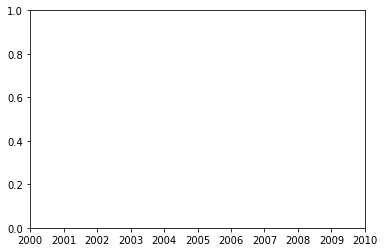

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
plt.plot(data['date'], data['event'],  "o",  markersize=2)
plt.show() #グラフを表示する

### 問題:
1. 上のグラフはどうしてこういう形になのか考えてみましょう。
2. 上のコードを変更して`time`と`temp`の関係がどんなものか、グラフで表現してみましょう。



### 2.頻度分布（ヒストグラム）

以下のようにするとグラフを表示できます。

```
plt.hist(頻度を知りたい要素, bins ="ビンの数")
plt.show()
```
例えば、ADCの頻度分布のグラフを作りたい場合は以下のようにやります。
コードを実行してみましょう。


In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
plt.hist(data['adc'], bins=100)
plt.show()

　

----
# 第４章　実践
----



## 1.時間変動を調べる
以下を変更して**dataＡ**について温度が１日の間に時間によってどう変化して
いるかが分かるようなグラフを作ってみてください。

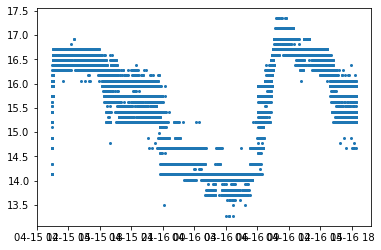

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
plt.plot(data['date'],data['temp'],  "o",  markersize=2)
plt.show()

##2.相関を調べる
1. 以下のコードを変更して何か関連がありそうな二つの要素を選んで自分なりに相関を調べてみましょう。

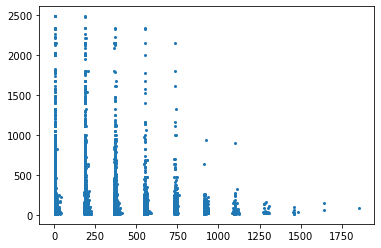

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
plt.plot(data['deadtime'],data['sipm'],  "o",  markersize=2)
plt.show()

## 2.角度が違う時の宇宙線到来頻度の違い
以下のコードを変更して、**dataA**と**dataB**と**dataC**の違いを比較して宇宙線の到来頻度の角度依存性を調べてみてください。


In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
print(analysis.numberOfEvent(data) / analysis.measurementTime(data) * 1000) #１秒当たりに起こるイベント数　

5522260.869565217


　

----
# 第５章　使える関数リスト
----

### データに制限を加える
- 方法:　`data = analysis.dataCut(データファイル,対象の要素,下限値、上限値)`
- コメント: 上限値を指定したくないときは`-1`にしてください。 `adc`に下限値を決めてノイズになるようなadcが小さいイベントを除去したり、 `time`に制限を加えて限られた時間のデータのみを解析したりなどで使います。
- 例：`adc`が200以上のみのデータについて、`adc`の頻度分布を描画する

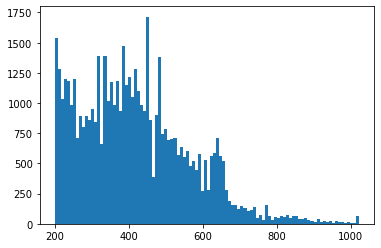

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
data = analysis.dataCut(data,'adc',200,-1)
plt.hist(data['adc'], bins=100)
plt.show()

### データの時間平均を取る
- 方法：`ave_data = analysis.timeAverage(data,平均を取る時間（秒）)`
- コメント：平均をとったデータには`num`というキーが追加されます。これは平均をとった時間の間に検出された数が格納されています。

- 例：色々な関係性を平均化してグラフにする（例えば１つ目のグラフはなめらかになっている）

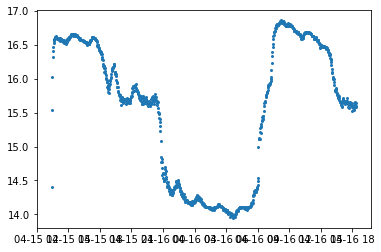

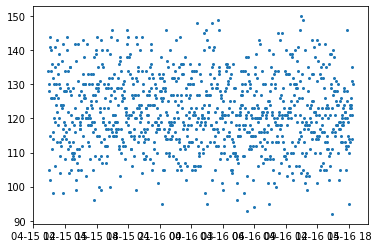

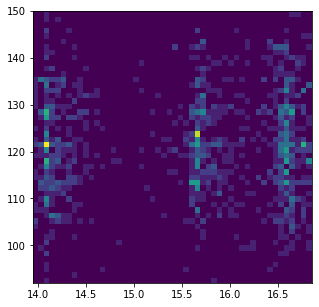

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
ave_data = analysis.timeAverage(data, 100) #100sごとにデータを平均したave_dataをつくる

plt.plot(ave_data['date'],ave_data['temp'],  "o",  markersize=2) #温度の時間変化の平均処理後
plt.show()

plt.plot(ave_data['date'],ave_data['num'],  "o",  markersize=2) #到来頻度の時間変化
plt.show()

plt.figure(figsize=(5,5)) #グラフのアスペクト比を１：１に調整
plt.hist2d(ave_data['temp'],ave_data['num'], bins=50) #adcと到来頻度の関係
plt.show()


### データの統計値を表示する
- 方法：`[mean, stdev, error] = analysis.dataStatistics(list))`
- コメント：`list`について、平均値、標準偏差、標準誤差が求められる
- 例：100秒当たりの検出数についての統計値を表示する

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
ave_data = analysis.timeAverage(data, 100)  # 100sごとにデータを平均したave_dataをつくる
[mean, stdev, error] = analysis.dataStatistics(ave_data['num'])
print('平均値：', mean,'  標準偏差：', stdev,'  標準偏差：', error)

平均値： 121.62512077294686   標準偏差： 10.795108985445376   標準偏差： 0.3355497011468676


### ２標本間でｚ検定を行う
- 方法：`analysis.zTest(list1, list2)`
- コメント：ｚ検定を行った際にｚ値が求められます。

- 2つのサンプルデータ間における１００秒当たりの検出数のｚ検定を行う。

１つ目のデータ　平均値： 121.62512077294686   標準偏差： 10.795108985445376   標準誤差： 0.3355497011468676
２つ目のデータ　平均値： 112.90314769975787   標準偏差： 11.05657625205254   標準誤差： 0.5440585498007218
z値：  13.644861038392586


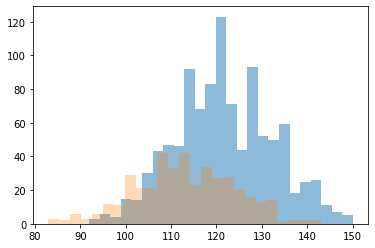

In [ ]:
data1 = analysis.loadData('dataA')  # dataにファイルの読み込み
ave_data1 = analysis.timeAverage(data1, 100)  # 100sごとにデータを平均したave_dataをつくる
[mean1, stdev1, error1] = analysis.dataStatistics(ave_data1['num'])
print('１つ目のデータ　平均値：', mean1,'  標準偏差：', stdev1,'  標準誤差：', error1)
data2 = analysis.loadData('dataC')  # dataにファイルの読み込み
ave_data2 = analysis.timeAverage(data2, 100)  # 100sごとにデータを平均したave_dataをつくる
[mean2, stdev2, error2] = analysis.dataStatistics(ave_data2['num'])
print('２つ目のデータ　平均値：', mean2,'  標準偏差：', stdev2,'  標準誤差：', error2)
print('z値： ',analysis.zTest(ave_data1['num'], ave_data2['num']))
plt.hist(ave_data1['num'], bins=25, alpha=0.5)
plt.hist(ave_data2['num'], bins=25, alpha=0.3)
plt.show()

　

----
# 第６章　各学校の応用例
----

### データの時間平均の時間変化を比較（秋田高校）


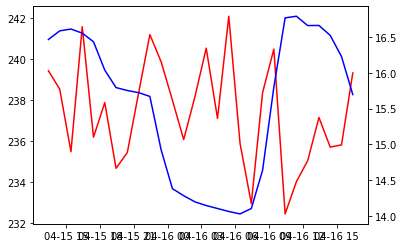

In [ ]:
data = analysis.loadData('dataA') #dataにファイルの読み込み
ave_data = analysis.timeAverage(data, 3600)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ave_data['date'], ave_data['adc'], markersize=2,color ='red')
ax2.plot(ave_data['date'],ave_data['temp'],markersize=2,color ='blue')
plt.show() #グラフを表示する

### 複数のdatファイルをまとめて1つのファイルにする（秋田高校）
複数日に取ったデータをまとめて処理するときに便利。
実行してしばらくすると、「ファイル」の中に新しいデータファイルが出来る。できたファイルを右クリックするとダウンロードすることができる。


In [ ]:
import pandas as pd           #複数日のデータをまとめて1つのファイルに結合
import csv
df_list = []
namelist = [#まとめるファイルの名前
            'dataA',
            'dataB']

for f in namelist:
    data = pd.read_csv(f,encoding="utf-8-sig",header =None)
    df_list.append(data)
    data2 = pd.concat(df_list)

data2.to_csv('total.dat',header =False,index =False)   #保存するファイル名

　

----
# バージョン
----


version | changes
--- | ---
1.1 | 各学校のサンプルデータやサンプル解析例を追加
1.1 | 湿度・気圧が取得できるCosmic Watchに対応
1.03 | 統計情報（標準偏差、標準誤差）の計算及びｚ検定が追加
1.02 | timeAverage()を追加して、時間平均を取れるように
1.01 | 途中で取り直したデータにも対応。データの追加ロードに対応、time、deadtimeを蓄積形式から各イベント情報に変更
1.00 | テストバージョン